In [75]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucsb-cs165b-winter-2022-machine-homework-3/sample_submission.csv
/kaggle/input/ucsb-cs165b-winter-2022-machine-homework-3/test.npy


## 1. Download data & visualize

The CIFAR-10 dataset contains _color_ or RGB images. Each image is 32 pixels in height and 32 pixels in width and has 3 channels (red, green and blue).

For training and validation, we will use the original CIFAR train/test splits. These can be downloaded through the `torchvision` module.

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torchvision import datasets

In [77]:
# checking if GPU is available or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [78]:
# torchvision has CIFAR10 dataset built in
train_ds = datasets.CIFAR10("/kaggle/working/data", train=True, download=True)
valid_ds = datasets.CIFAR10("/kaggle/working/data", train=False)

Files already downloaded and verified


Our test set consists of similar color images that are not present in the original _CIFAR-10_ dataset. 
We will manually load the csv file into a `DataSet` class

In [79]:
class TestData(datasets.VisionDataset):
    
    filepath = "/kaggle/input/ucsb-cs165b-winter-2022-machine-homework-3/test.npy"
    
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data = np.load(self.filepath)
    
    def __getitem__(self, index: int):
        
        img = self.data[index]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img
        
    def __len__(self):
        return len(self.data)

test_ds = TestData("/kaggle/working/data")

Now visualize some of the training examples with `matplotlib`

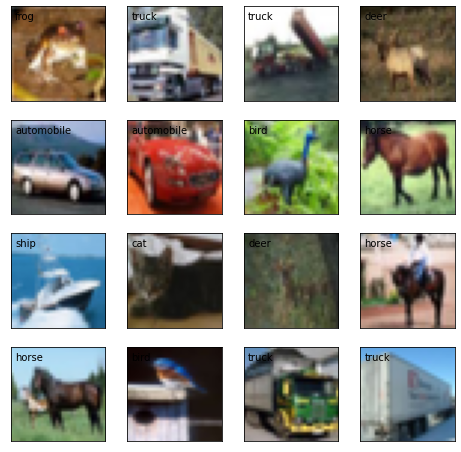

In [80]:
# take the first 16 samples and visualize them in a grid
fig = plt.figure(figsize=(8, 8))
cls_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', \
            5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(train_ds[i][0])
    ax.text(1, 4, str(cls_dict[train_ds[i][1]]))
plt.show()

## 2. Prepare Datasets for Training
As the default loaded images are in PIL format, we need to convert them into pytorch tensors. This can be done with `torchvision.transforms`. After that, we need to wrap the datasets with `torch.utils.data.DataLoader` to automatically handle shuffling and batching during training.

In [81]:
from torchvision import transforms

In [82]:
# first transform the images to tensor format, 
# then normalize the pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_ds.transform = transform
valid_ds.transform = transform
test_ds.transform = transform

In [83]:
train_ds[0][0].shape

torch.Size([3, 32, 32])

In [84]:
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_ds, batch_size=1000
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1000
)

## 3. Define the Model Structure
Now we have the data prepared, next step is to define the structure of the _convolutional neural network_ (CNN) model in pytorch. Our baseline model is the [LeNet](https://en.wikipedia.org/wiki/LeNet), consisting of two convolutional, two pooling, and three dense layers.

In [85]:
import torch.nn as nn
import torch.nn.functional as F

In [86]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

convnet = ConvNet().to(device)
print(convnet)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 4. Define a loss function and optimizer

Let’s use a classification _Cross-Entropy loss_ and _SGD with momentum_.

In [87]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(convnet.parameters(), lr=0.001, momentum=0.9)

## 5. Define the training and validation loops
Each training step consists of a feed forward pass and a backward propagation pass. Training loss is computed using the ground truth labels and the outputs from the forward pass. The purpose of the backpropagation step is to calculate the gradient of the loss with respect to all model parameters. The optimizer adjusts the model parameters trying to minimize the loss. 

The validation process consists of just the forward pass and helps us to estimate how well the model generalizes to unseen data. 

In [88]:
import torch.optim as optim
from tqdm import tqdm

In [89]:
def train(epoch, model, trainloader, criterion, optimizer):
    model.train()
    running_loss, total, correct = 0.0, 0, 0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # compare predictions to ground truth
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # gather statistics
        running_loss += loss.item()
        
    running_loss /= len(trainloader)
    
    print('Training | Epoch: {}| Loss: {:.3f} | Accuracy on 50000 train images: {:.1f}'.format \
          (epoch+1, running_loss, 100 * correct / total))


In [90]:
def validate(epoch, model, valloader, criterion):
    model.eval()
    running_loss, total, correct = 0.0, 0, 0
    for i, data in tqdm(enumerate(valloader, 0)):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # compare predictions to ground truth
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # gather statistics
        running_loss += loss.item()
        
    running_loss /= len(valloader)
    
    print('Validation | Epoch: {}| Loss: {:.3f} | Accuracy on 10000 val images: {:.1f}'.format \
          (epoch+1, running_loss, 100 * correct / total))

## 6. Train and validate the model

Now that everything is setup, we can train the model for multiple epochs and then evaluate it on the validation set.

In [91]:
# training for 20 epochs
for epoch in range(20):
    train(epoch, convnet, train_loader, criterion, optimizer)

# validating
validate(epoch, convnet, valid_loader, criterion)

782it [00:17, 45.05it/s]


Training | Epoch: 1| Loss: 2.303 | Accuracy on 50000 train images: 10.6


782it [00:16, 46.91it/s]


Training | Epoch: 2| Loss: 2.283 | Accuracy on 50000 train images: 16.8


782it [00:17, 45.39it/s]


Training | Epoch: 3| Loss: 2.099 | Accuracy on 50000 train images: 24.3


782it [00:16, 46.51it/s]


Training | Epoch: 4| Loss: 1.886 | Accuracy on 50000 train images: 32.4


782it [00:17, 45.33it/s]


Training | Epoch: 5| Loss: 1.722 | Accuracy on 50000 train images: 37.3


782it [00:16, 46.28it/s]


Training | Epoch: 6| Loss: 1.605 | Accuracy on 50000 train images: 41.2


782it [00:16, 46.01it/s]


Training | Epoch: 7| Loss: 1.527 | Accuracy on 50000 train images: 44.1


782it [00:17, 45.91it/s]


Training | Epoch: 8| Loss: 1.469 | Accuracy on 50000 train images: 46.5


782it [00:17, 45.02it/s]


Training | Epoch: 9| Loss: 1.421 | Accuracy on 50000 train images: 48.7


782it [00:17, 45.40it/s]


Training | Epoch: 10| Loss: 1.383 | Accuracy on 50000 train images: 50.0


782it [00:16, 46.21it/s]


Training | Epoch: 11| Loss: 1.348 | Accuracy on 50000 train images: 51.4


782it [00:16, 46.75it/s]


Training | Epoch: 12| Loss: 1.314 | Accuracy on 50000 train images: 52.5


782it [00:17, 45.39it/s]


Training | Epoch: 13| Loss: 1.284 | Accuracy on 50000 train images: 54.0


782it [00:16, 47.49it/s]


Training | Epoch: 14| Loss: 1.259 | Accuracy on 50000 train images: 54.8


782it [00:17, 45.06it/s]


Training | Epoch: 15| Loss: 1.226 | Accuracy on 50000 train images: 56.1


782it [00:16, 47.35it/s]


Training | Epoch: 16| Loss: 1.201 | Accuracy on 50000 train images: 57.2


782it [00:17, 44.40it/s]


Training | Epoch: 17| Loss: 1.173 | Accuracy on 50000 train images: 58.3


782it [00:16, 47.24it/s]


Training | Epoch: 18| Loss: 1.143 | Accuracy on 50000 train images: 59.3


782it [00:17, 45.36it/s]


Training | Epoch: 19| Loss: 1.120 | Accuracy on 50000 train images: 60.3


782it [00:16, 47.41it/s]


Training | Epoch: 20| Loss: 1.097 | Accuracy on 50000 train images: 61.2


10it [00:03,  2.81it/s]

Validation | Epoch: 20| Loss: 1.148 | Accuracy on 10000 val images: 59.6


## 6. Predict and Submit
If you are satisfied with your model performance on the validation set, you can predict the labels for the test set and submit your results.

In [92]:
def predict(model,testloader):
    
    model.eval()
    preds = []
    with torch.no_grad():
        # labels are not available for the actual test set
        for feature in tqdm(testloader):
            # calculate outputs by running images through the network
            outputs = model(feature.to(device))
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.tolist())
    
    return preds

Now prepare your submission file and submit. Submissions should be made in CSV files with two columns: an `id` column and a `label` column. Make sure the order of the predictions is the same with the input `test.csv`.

In [93]:
import csv

predictions = predict(convnet, test_loader)
with open("submission.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "label"])
    for i, label in enumerate(predictions):
        writer.writerow([i, label])

100%|██████████| 2/2 [00:00<00:00,  7.42it/s]
